In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import os
import string

In [2]:
import cv2

BLANK = " "
ALL_CHARS = string.ascii_letters + string.digits + "!\"#$%&'()*+,-./:;?@[\\]^_`{|}~" + BLANK
CHAR_IDX = {c: i for i, c in enumerate(ALL_CHARS)}
IDX_CHAR = {i: c for c, i in CHAR_IDX.items()}

blank_idx = len(ALL_CHARS)
num_classes = len(ALL_CHARS) + 1  # +1 для blank

class OCRDataset(Dataset):
    def __init__(self, img_dir, labels_file, img_size=(128,32), transform=None):
        self.img_dir = img_dir
        self.img_size = img_size
        self.transform = transform

        self.samples = []
        with open(labels_file, 'r') as f:
            for line in f:
                fname, label = line.strip().split('\t')
                self.samples.append((fname, label.upper()))
                
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    def __len__(self):
        return len(self.samples)

    def text_to_indices(self, text):
        return [CHAR_IDX[c] for c in text]

    def __getitem__(self, idx):
        fname, label = self.samples[idx]
        img_path = os.path.join(self.img_dir, fname)
        img = Image.open(img_path).convert('L')  # grayscale
        img = img.resize(self.img_size, Image.BILINEAR)

        # PIL -> numpy для CLAHE
        img_np = np.array(img)
        img_np = self.clahe.apply(img_np)  # повысить контраст
        img = Image.fromarray(img_np)

        # To Tensor + Normalize [-1,1]
        img = torch.tensor(np.array(img)/255.0, dtype=torch.float32).unsqueeze(0)
        img = (img - 0.5) / 0.5

        label_idx = torch.tensor(self.text_to_indices(label), dtype=torch.long)
        return img, label_idx, len(label_idx)

# Collate_fn для батчей разной длины
def ocr_collate_fn(batch):
    imgs, labels, lengths = zip(*batch)
    imgs = torch.stack(imgs, 0)
    labels = torch.cat(labels)
    lengths = torch.tensor(lengths, dtype=torch.long)
    return imgs, labels, lengths


In [3]:
from torch.utils.data import DataLoader


img_dir = "/kaggle/input/sintetic-texts-multibackground/ocr_dataset/train/white"
labels_file = "/kaggle/input/sintetic-texts-dataset/ocr_dataset/labels.txt"

dataset = OCRDataset(img_dir, labels_file)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=ocr_collate_fn)

for imgs, labels, lengths in dataloader:
    print(imgs.shape)   # [batch, 1, H, W]
    print(labels.shape)
    print(lengths)
    break


torch.Size([32, 1, 32, 128])
torch.Size([1060])
tensor([37, 36, 31, 36, 32, 44, 37, 33, 36, 28, 41, 35, 31, 30, 33, 39, 29, 32,
        30, 26, 32, 43, 31, 36, 36, 27, 31, 31, 25, 23, 42, 27])


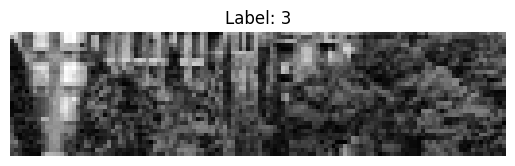

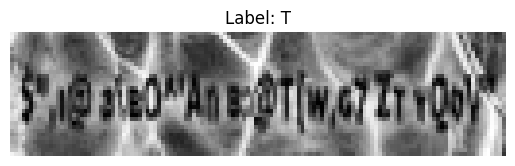

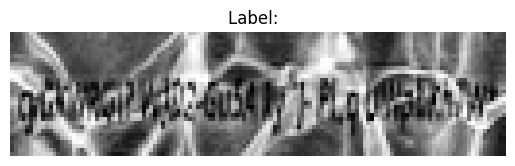

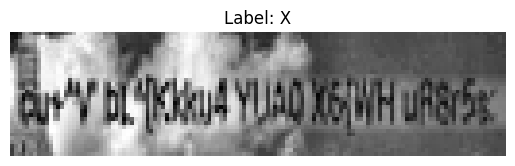

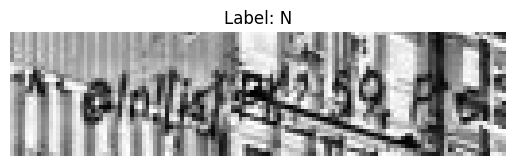

In [21]:
imgs, labels, lengths = next(iter(train_loader))

for i in range(5):
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    l = lengths[i].item()
    word_labels = labels[i][:l] if labels[i].dim() > 0 else labels[i].unsqueeze(0)
    label_text = "".join([IDX_CHAR[c.item()] for c in word_labels])
    
    plt.title("Label: " + label_text)
    plt.axis('off')
    plt.show()

In [12]:
import torch
import torch.nn as nn

class CRNN(nn.Module):
    def __init__(self, img_h=32, num_channels=1, num_classes=37, hidden_size=128):
        super(CRNN, self).__init__()
        
        # CNN backbone (лёгкий, но устойчивый)
        self.cnn = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),    # H: 32 -> 16, W: 128 -> 64

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),    # H: 16 -> 8,  W: 64 -> 32

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 1), (2, 1)),  # H: 8 -> 4, W: stays 32

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        
        # BiLSTM
        self.rnn = nn.LSTM(
            input_size=256*4,    # C*H (после CNN)
            hidden_size=hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )
        
        # Классификатор
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        # x: [B, 1, H, W]
        conv = self.cnn(x)             # [B, C, H', W']
        b, c, h, w = conv.size()
        
        conv = conv.permute(0, 3, 1, 2)  # [B, W', C, H']
        conv = conv.reshape(b, w, c*h)   # [B, W', C*H']
        
        rnn_out, _ = self.rnn(conv)      # [B, W', hidden*2]
        logits = self.fc(rnn_out)        # [B, W', num_classes]
        
        # для CTC нужно [T, B, C]
        logits = logits.permute(1, 0, 2) # [W', B, num_classes]
        return logits

In [13]:
from torch.utils.data import Subset, DataLoader
import random

dataset_size = len(dataset)
indices = list(range(dataset_size))
random.shuffle(indices)

train_split = 0.7
val_split = 0.15
test_split = 0.15

train_end = int(train_split * dataset_size)
val_end = train_end + int(val_split * dataset_size)

train_indices = indices[:train_end]
val_indices = indices[train_end:val_end]
test_indices = indices[val_end:]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=ocr_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=ocr_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=ocr_collate_fn)

In [14]:
# === Функция декодирования предсказаний ===
def decode_predictions(logits):
    pred = logits.argmax(2).permute(1,0)  # [batch, seq_len]
    texts = []
    for p in pred:
        chars = []
        prev = -1
        for idx in p:
            if idx != prev and idx != len(ALL_CHARS)-1:  # игнор blank и повторы
                chars.append(IDX_CHAR[idx.item()])
            prev = idx
        texts.append("".join(chars))
    return texts

In [15]:
import editdistance
def cer(gt, pred):
    return editdistance.eval(gt, pred) / max(len(gt), 1)

def word_accuracy(gt, pred):
    return int(gt == pred)

In [16]:
def evaluate_model(model, loader):
    model.eval()
    total_cer = 0
    total_acc = 0
    total_samples = 0

    with torch.no_grad():
        for imgs, labels, lengths in loader:
            imgs, labels, lengths = imgs.to(device), labels.to(device), lengths.to(device)
            logits = model(imgs)
            preds = decode_predictions(logits)

            labels_text = []
            start = 0
            for l in lengths:
                labels_text.append("".join([IDX_CHAR[i.item()] for i in labels[start:start+l]]))
                start += l

            for gt, pred_text in zip(labels_text, preds):
                total_cer += cer(gt, pred_text)
                total_acc += word_accuracy(gt, pred_text)
                total_samples += 1

    avg_cer = total_cer / total_samples
    avg_acc = total_acc / total_samples
    return avg_cer, avg_acc

Epoch 1/5 | Train Loss: nan | Val Loss: nan | Val CER: 0.9855 | Val Word Acc: 0.0000


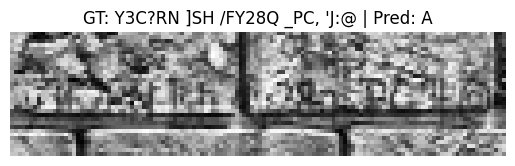

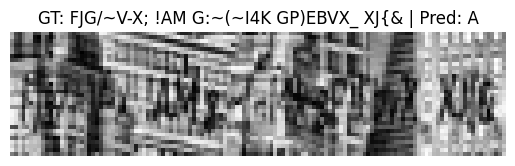

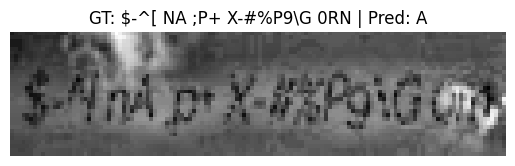

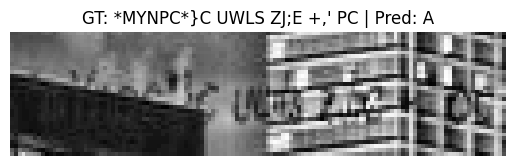

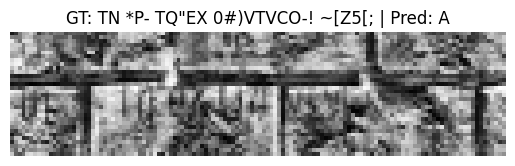

Epoch 2/5 | Train Loss: nan | Val Loss: nan | Val CER: 0.9855 | Val Word Acc: 0.0000


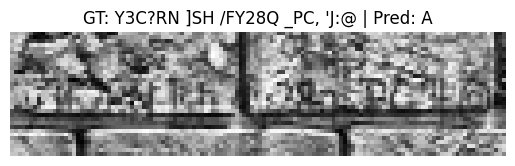

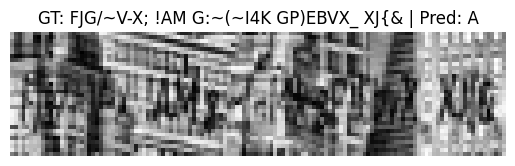

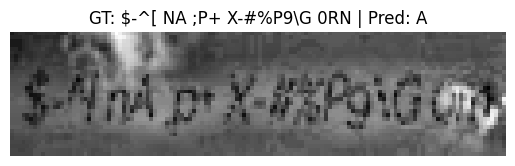

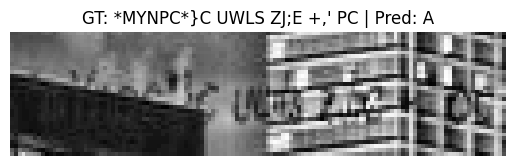

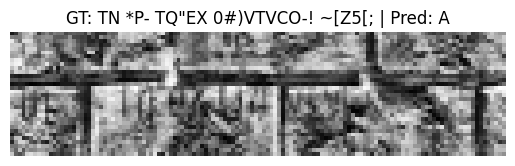

Epoch 3/5 | Train Loss: nan | Val Loss: nan | Val CER: 0.9855 | Val Word Acc: 0.0000


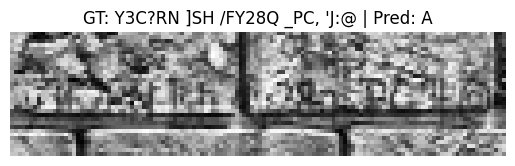

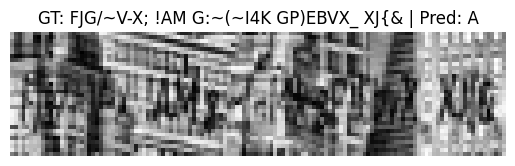

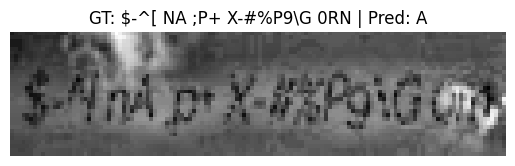

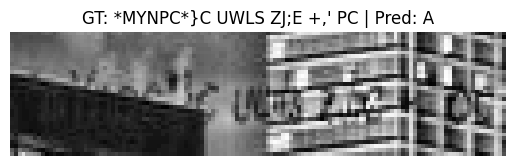

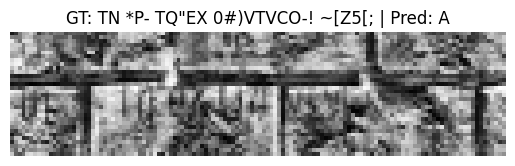

Epoch 4/5 | Train Loss: nan | Val Loss: nan | Val CER: 0.9855 | Val Word Acc: 0.0000


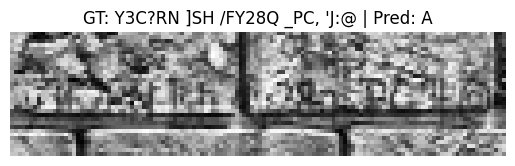

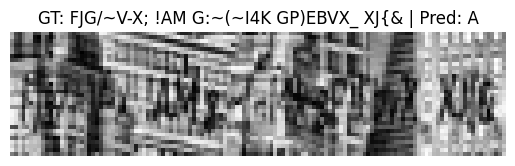

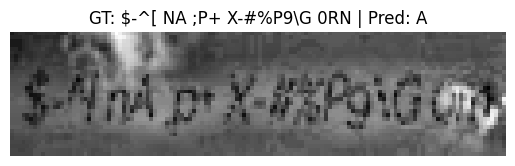

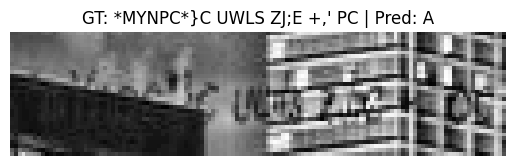

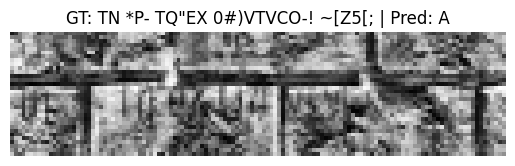

Epoch 5/5 | Train Loss: nan | Val Loss: nan | Val CER: 0.9855 | Val Word Acc: 0.0000


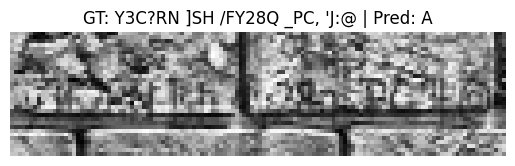

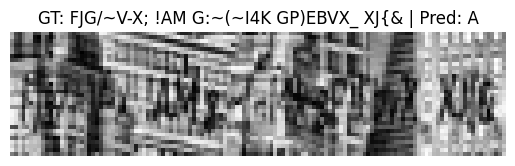

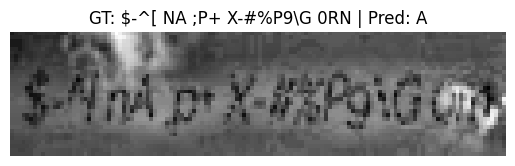

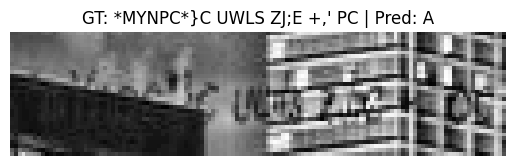

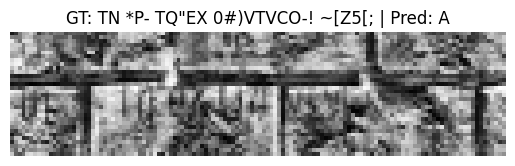

In [17]:
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
crnn = CRNN().to(device)
optimizer = optim.Adam(crnn.parameters(), lr=1e-3)
ctc_loss = nn.CTCLoss(blank=blank_idx)

num_epochs = 5
for epoch in range(num_epochs):
    # ---- Обучение ----
    crnn.train()
    train_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False)
    for imgs, labels, lengths in loop:
        imgs, labels, lengths = imgs.to(device), labels.to(device), lengths.to(device)
        optimizer.zero_grad()
        logits = crnn(imgs)
        log_probs = F.log_softmax(logits, dim=2)
        input_lengths = torch.full(size=(logits.size(1),), fill_value=logits.size(0), dtype=torch.long).to(device)
        loss = ctc_loss(log_probs, labels, input_lengths, lengths)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        loop.set_postfix(loss=train_loss / (loop.n + 1))
    train_loss /= len(train_loader)

    # ---- Валидация ----
    crnn.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels, lengths in val_loader:
            imgs, labels, lengths = imgs.to(device), labels.to(device), lengths.to(device)
            logits = crnn(imgs)
            log_probs = F.log_softmax(logits, dim=2)
            input_lengths = torch.full(size=(logits.size(1),), fill_value=logits.size(0), dtype=torch.long).to(device)
            loss = ctc_loss(log_probs, labels, input_lengths, lengths)
            val_loss += loss.item()
        val_loss /= len(val_loader)

    # ---- Метрики валидации ----
    val_cer, val_acc = evaluate_model(crnn, val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val CER: {val_cer:.4f} | Val Word Acc: {val_acc:.4f}")

    # ---- Визуализация 5 примеров ----
    imgs, labels, lengths = next(iter(val_loader))
    imgs = imgs.to(device)
    logits = crnn(imgs)
    preds = decode_predictions(logits)
    labels_text = []
    start = 0
    for l in lengths:
        labels_text.append("".join([IDX_CHAR[i.item()] for i in labels[start:start+l]]))
        start += l

    for i in range(min(5, len(preds))):
        plt.imshow(imgs[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {labels_text[i]} | Pred: {preds[i]}")
        plt.axis('off')
        plt.show()

In [ ]:
test_cer, test_acc = evaluate_model(crnn, test_loader)
print(f"Test CER: {test_cer:.4f}, Word Accuracy: {test_acc:.4f}")

In [ ]:
def get_hardest_examples(model, loader, top_k=5):
    model.eval()
    hardest = [] 

    with torch.no_grad():
        for imgs, labels, lengths in loader:
            imgs, labels, lengths = imgs.to(device), labels.to(device), lengths.to(device)
            logits = model(imgs)
            preds = decode_predictions(logits)

            labels_text = []
            start = 0
            for l in lengths:
                labels_text.append("".join([IDX_CHAR[i.item()] for i in labels[start:start+l]]))
                start += l

            for i in range(len(preds)):
                current_cer = cer(labels_text[i], preds[i])
                hardest.append((current_cer, imgs[i].cpu(), labels_text[i], preds[i]))

    # Сортируем по CER по убыванию
    hardest.sort(key=lambda x: x[0], reverse=True)
    return hardest[:top_k]

# ---- Top-2 hardest examples на тесте ----
top_hardest_test = get_hardest_examples(crnn, test_loader, top_k=2)
print("Top-2 hardest examples on TEST set:")
for cer_val, img, gt, pred_text in top_hardest_test:
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"CER: {cer_val:.2f} | GT: {gt} | Pred: {pred_text}")
    plt.axis('off')
    plt.show()